In [10]:
### imports

import numpy as np
from functools import reduce
import torch
import matplotlib.pyplot as plt

In [11]:
### Classical Helper Functions ###


def permutations(arr):
    if not arr:
        return [[]]
    res = []
    for i in range(len(arr)):
        curr = arr[i]
        others = arr[:i] + arr[i + 1 :]
        for permutation in permutations(others):
            res.append([curr] + permutation)
    return res


def add(a, b):
    return a + b


def mult(a, b):
    return a * b


def int_to_bitarray(input, n):
    return [int(bit) for bit in bin(input)[2:].zfill(n)]

In [12]:
indices = [
    [0, 1],
    [2, 3],
    [4, 5],
    [1, 2],
    [3, 4],
    [0, 1],
    [2, 3],
    [4, 5],
    [1, 2],
    [3, 4],
]
n = 3
m = 3

At = torch.zeros((8, 8), dtype=torch.complex128)
for i in range(7):
    At[i, i] = 1
At[7, 7] = -1

In [13]:
### Neural Network Helper Functions ###


# This function returns an NxN matrix representing an Hadamard (Rx, actually, in this case)
# applied to the i-th and j-th modes.
def hadamard(param, i, j, N):
    res = torch.zeros((N, N), dtype=torch.complex128)
    for k in range(N):
        for l in range(N):
            if k == i and l == i:
                res[k, l] = torch.cos(param / 2)
            elif k == i and l == j:
                res[k, l] = 1j * torch.sin(param / 2)
            elif k == j and l == i:
                res[k, l] = 1j * torch.sin(param / 2)
            elif k == j and l == j:
                res[k, l] = torch.cos(param / 2)
            elif k == l:
                res[k, l] = 1
    return res


# This function takes a list of phases for n+m modes and applies each phase to each mode
# and then takes a list of thetas and applies Rx(theta) to the modes identified by the corresponding
# element of "indices". All of this is multiplied using matrix products to return a single unitary U
def get_U(phases, thetas, n, m, indices):
    U0 = torch.zeros((n + m, n + m), dtype=torch.complex128)
    for i in range(n + m):
        U0[i, i] = torch.exp(1j * phases[i])
    matrices = [hadamard(param, i[0], i[1], n + m) for param, i in zip(thetas, indices)]
    U = reduce(lambda x, y: torch.matmul(y, x), matrices, U0)
    return U


# This function implements the conversion from the unitary matrix U to the
# desired matrix where the m auxiliary modes are all in fock state |1>
# Implementation is based on Uskov et. al. (2009)
def get_A(U, n, m):
    A = torch.zeros((2**n, 2**n), dtype=torch.complex128)
    for row in range(2**n):
        row_bits = int_to_bitarray(row, n)
        for col in range(2**n):
            col_bits = int_to_bitarray(col, n)
            if sum(row_bits) == sum(col_bits):
                in_indices = [i for i, val in enumerate(col_bits) if val] + list(
                    range(n, n + m)
                )
                out_indices = [o for o, val in enumerate(row_bits) if val] + list(
                    range(n, n + m)
                )
                A[row, col] = reduce(
                    torch.add,
                    [
                        reduce(
                            torch.multiply, [U[i, j] for i, j in zip(in_indices, oi)]
                        )
                        for oi in permutations(out_indices)
                    ],
                )
    return A


# Get the fidelity based on Uskov et. al. (2009)
def get_fidelity(A, At):
    B = A / A[0, 0]
    numer = torch.trace(B.conj() @ At) * torch.trace(At.conj() @ B)
    denom = torch.trace(B.conj() @ B) * torch.trace(At.conj() @ At)
    fidelity = numer / denom
    return fidelity.real


# Alternative distance function to use as a loss function.
def get_dist(A, At):
    B = A / A[0, 0]
    return torch.sum(torch.square(torch.abs(B - At)))


# The performance of the CCZ
def get_success(A):
    return A[0, 0].real ** 2

In [14]:
### Neural Network Optimization Function ###


# neural network optimization with for any gate
# with n input modes and m auxiliary modes with an array of indices representing
# parametrized Rx(theta) gates. We perform nsteps steps for a gradient descent of this
# theoretically accurate neural network model.
def neural_network_optimization(
    n, m, indices, generator, nsteps, _get_loss, _get_fidelity, printing=True
):

    phases = (
        2 * torch.pi * torch.rand(n + m, generator=generator, dtype=torch.float64)
        - torch.pi
    )
    thetas = (
        2
        * torch.pi
        * torch.rand(len(indices), generator=generator, dtype=torch.float64)
        - torch.pi
    )
    for param in [phases, thetas]:
        param.requires_grad = True

    optimizer = torch.optim.SGD([phases, thetas], 0.025)

    fidelities = []
    losses = []
    successes = []

    for step in range(nsteps):

        U = get_U(phases, thetas, n, m, indices)
        A = get_A(U, n, m)

        loss = _get_loss(A)
        losses.append(loss.item())

        fidelity = _get_fidelity(A)
        fidelities.append(fidelity.item())

        success = get_success(A)
        successes.append(success.item())

        if printing:
            print(step, loss.item(), fidelity.item(), get_success(A).item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Optimized phases:", phases.detach().numpy() % (2 * np.pi) - np.pi)
    print("Optimized thetas:", thetas.detach().numpy() % (2 * np.pi) - np.pi)
    print("Fidelity: ", fidelity.item())
    print("Success: ", success.item())

    return phases, thetas, A, fidelities, successes, losses

In [15]:
# Get the parameters for the CZ gate on two data modes and 2 auxiliary modes

g = torch.Generator().manual_seed(3141592653 + 10)

n, m = 2, 2
indices = [[0, 2], [1, 3], [0, 1], [2, 3]]
steps = 5000
At = torch.tensor(
    [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]], dtype=torch.complex128
)

print("CZ gate optimizations: reproducing the results from the paper...")

phases, thetas, A, fidelities, successes, losses = neural_network_optimization(
    n,
    m,
    indices,
    g,
    steps,
    lambda A: get_dist(A, At) - 0.1 * get_success(A),
    lambda A: get_fidelity(A, At),
    printing=False,
)

CZ gate optimizations: reproducing the results from the paper...
Optimized phases: [-3.55271368e-15  3.55271368e-15 -2.79388352e+00  2.75951385e+00]
Optimized thetas: [-1.23595969  1.23595969 -1.21052558 -2.52096725]
Fidelity:  0.9999946168246274
Success:  0.07449044265175285


Text(0.5, 1.0, 'Fidelity of CZ gate optimization vs. Num backpropagation steps.')

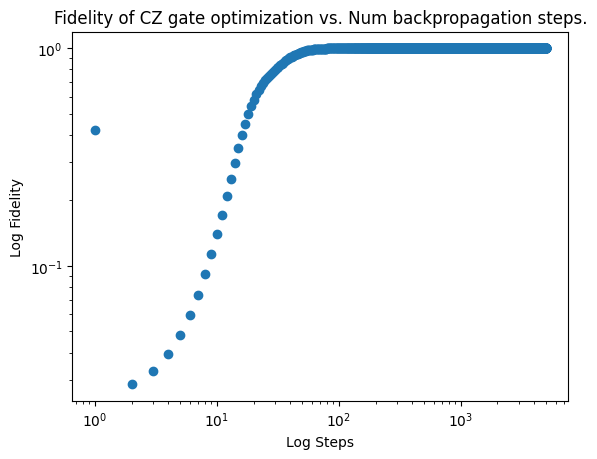

In [16]:
plt.scatter(range(1, len(fidelities) + 1), fidelities)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Log Steps")
plt.ylabel("Log Fidelity")
plt.title("Fidelity of CZ gate optimization vs. Num backpropagation steps.")

Text(0.5, 1.0, 'Performance of CZ gate optimization vs. Num backpropagation steps.')

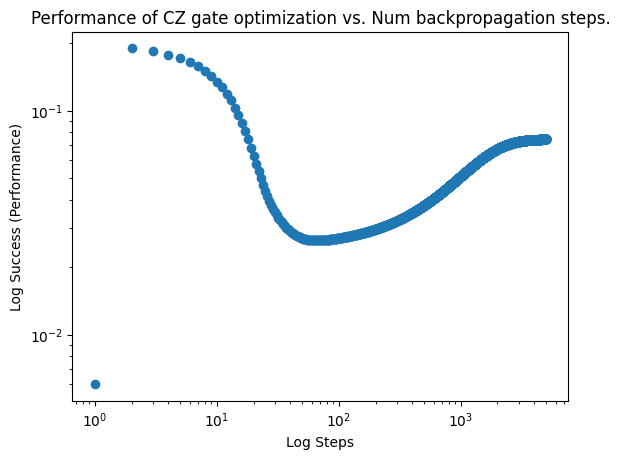

In [17]:
plt.scatter(range(1, len(successes) + 1), successes)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Log Steps")
plt.ylabel("Log Success (Performance)")
plt.title("Performance of CZ gate optimization vs. Num backpropagation steps.")

In [18]:
# Get the parameters for the CCZ gate on 3 data modes and 3 auxiliary modes

g = torch.Generator().manual_seed(3141592653 + 10)

n, m = 3, 3
indices = [
    [2, 3],
    [2, 4],
    [2, 5],
    [1, 3],
    [1, 4],
    [1, 5],
    [0, 3],
    [0, 4],
    [0, 5],
    [0, 1],
    [1, 2],
    [0, 2],
]

steps = 100

At = torch.zeros((8, 8), dtype=torch.complex128)
for i in range(7):
    At[i, i] = 1
At[7, 7] = -1

print("CCZ gate optimizations: reproducing the results from the paper...")

phases, thetas, A, fidelities, successes, losses = neural_network_optimization(
    n,
    m,
    indices,
    g,
    steps,
    lambda A: get_dist(A, At),
    lambda A: get_fidelity(A, At),
    printing=False,
)

CCZ gate optimizations: reproducing the results from the paper...
Optimized phases: [ 2.16070423  1.39484406 -2.31018444  2.28104926 -0.47273465  1.88887472]
Optimized thetas: [ 2.98692581 -1.4810454   2.87106823  2.95903443 -1.6391433  -1.84388203
  2.87337205 -3.06822141  2.29771258  1.22874777 -0.20902587  0.23590594]
Fidelity:  0.8321023420655322
Success:  0.08786061092728603
